In [1]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.cluster import KMeans
from pykalman import KalmanFilter 
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt          
%matplotlib inline
#%matplotlib notebook
#import mpld3

In [2]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [3]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
#one day in seconds
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']
df['logPrice'] = df['weightedAverage'].apply(np.log)

In [4]:
def fitKCA(t,z,q,fwd=0):
    """
        Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
        Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    """
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
               [0,1,h],
               [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2)Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf = kf.em(z)
    #4) Smooth
    x_mean,x_covar = kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                                          filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1) 
    for i in range(1,x_covar.shape[1]): 
        x_std_=x_covar[:,i,i]**.5 
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1) 
    return x_mean,x_std,x_covar

In [14]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [32]:
def v_a(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    x_mean,x_std,x_covar=fitKCA(df.date.values, df.y.values, .1) 
    
    df['velocity'] = x_mean[:,1]
    df['acceleration'] = x_mean[:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    p_df = df[['ds', 'velocity', 'acceleration']].copy()

    p_df['y'] = p_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    p_df['y'] = p_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


count    630.000000
mean       0.000115
std        0.004623
min       -0.036574
25%       -0.000969
50%        0.000159
75%        0.001487
max        0.023034
Name: velocity, dtype: float64
count    6.300000e+02
mean    -2.583030e-11
std      6.060981e-08
min     -3.686670e-07
25%     -1.552247e-08
50%      8.347758e-10
75%      1.827051e-08
max      3.914632e-07
Name: acceleration, dtype: float64


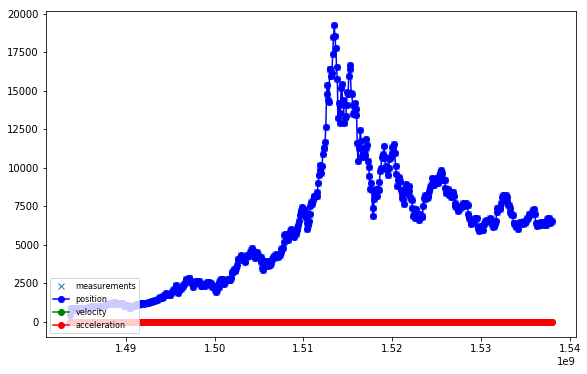

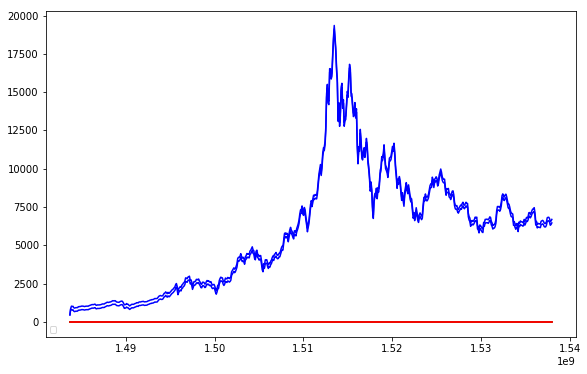

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


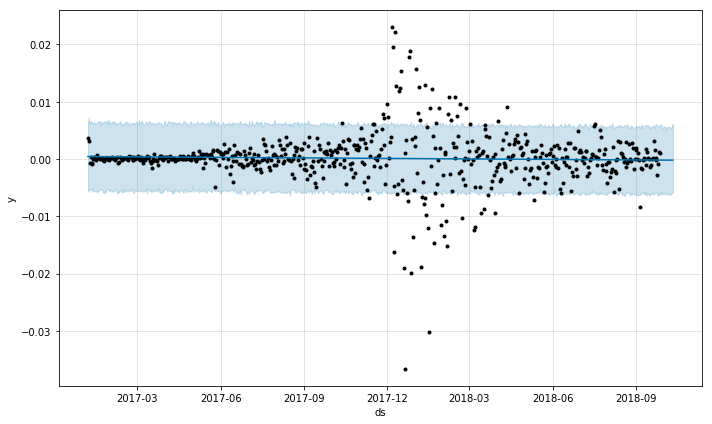

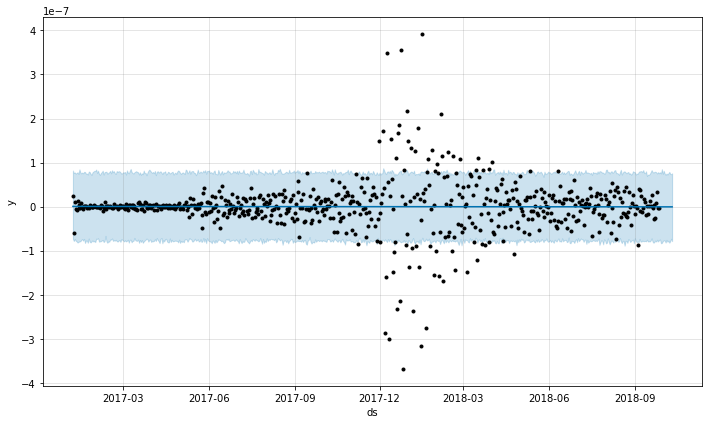

In [33]:
v_a(df)

In [5]:
x_mean,x_std,x_covar=fitKCA(df.date.values,df.y.values,1)

/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


In [6]:
# Mean Acceleration

In [7]:
print(x_mean[0,2])

9.245833262445664e-08


In [8]:
# Std Acceleration

In [9]:
print(x_std[0,2])

2.198910952332317e-05


In [10]:
# Mean Velocity/Inertia

In [11]:
print(x_mean[0,1])

0.0007104587640877943


In [12]:
# Std Velocity/Inertia

In [13]:
print(x_std[0,1])

0.9484217397727459


## Figure 1: KCA estimated mean states

Text(0.5,1,'Measurements: Weighted Average Prices')

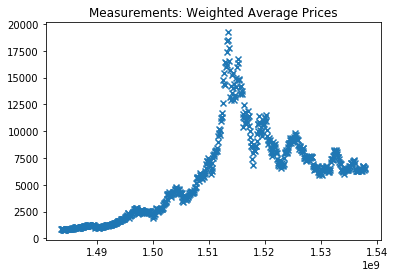

In [16]:
#measurements
plt.scatter(df.date, df.weightedAverage, marker='x')
plt.title('Measurements: Weighted Average Prices')

Text(0.5,1,'Position')

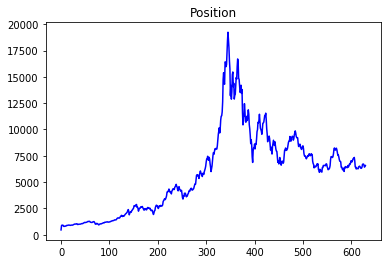

In [17]:
plt.plot(x_mean[:,0],color='blue') 
plt.title('Position')

Text(0.5,1,'Velocity')

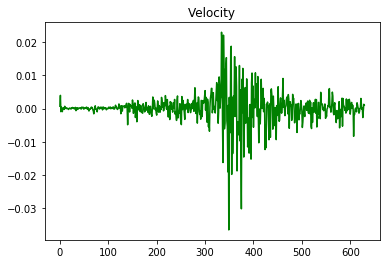

In [18]:
#velocity
plt.plot(x_mean[:,1],color='green') 
plt.title('Velocity')

Text(0.5,1,'Acceleration')

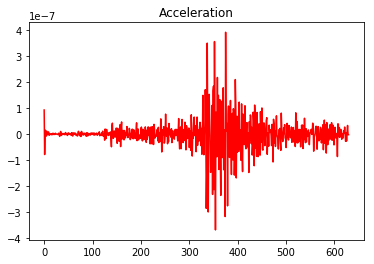

In [19]:
#acceleration
plt.plot(x_mean[:,2],color='red')
plt.title('Acceleration')

In [20]:
# couldn't get axis ranges to change, even after doing what this indicated:
# https://stackoverflow.com/questions/7733693/matplotlib-overlay-plots-with-different-scales
# will play around more in the days to come

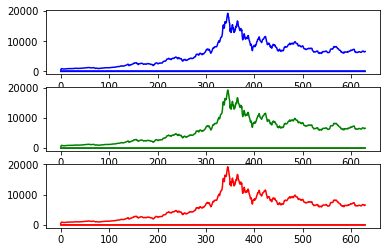

In [21]:
fig, axes = plt.subplots(nrows=3)

colors = ('b', 'g', 'r')
for ax, color in zip(axes, colors):
    #data = np.random.random(1) * np.random.random(10)
    ax.plot(x_mean[:,0],color=color)
    ax.plot(x_mean[:,1],color=color)
    ax.plot(x_mean[:,2],color=color)
    #ax.plot(data, marker='o', linestyle='none', color=color)

plt.show()

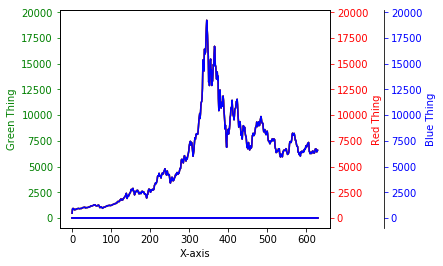

In [22]:
# To make things reproducible...
np.random.seed(1977)

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)
# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))
# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Green', 'Red', 'Blue')
for ax, color in zip(axes, colors):
    ax.plot(x_mean[:,0],color=color)
    ax.plot(x_mean[:,1],color=color)
    ax.plot(x_mean[:,2],color=color)
    #data = np.random.random(1) * np.random.random(10)
    #ax.plot(data, marker='o', linestyle='none', color=color)
    ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
axes[0].set_xlabel('X-axis')

plt.show()

## Figure 2 (shows that FFT extracts a signal very similar to the first state component extracted by KCA) 

In [23]:
# Not sure how to display this better...zooming in still doesn't show detail as in the paper

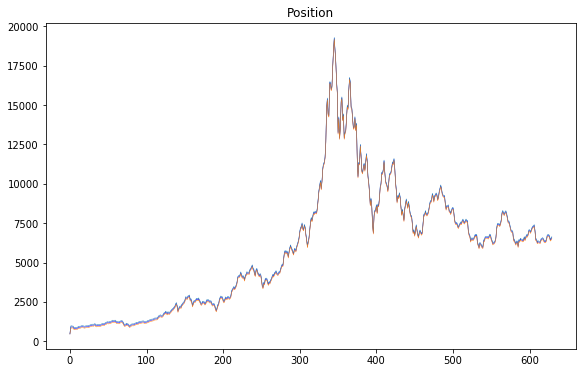

In [24]:
#mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [9.5,6] #width,height
#position
upper_error_bars = x_mean[:,0] + x_std[:,0]
lower_error_bars = x_mean[:,0] - x_std[:,0]
plt.plot(x_mean[:,0],color='blue',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)
plt.title('Position')
plt.show()

Text(0.5,1,'Velocity')

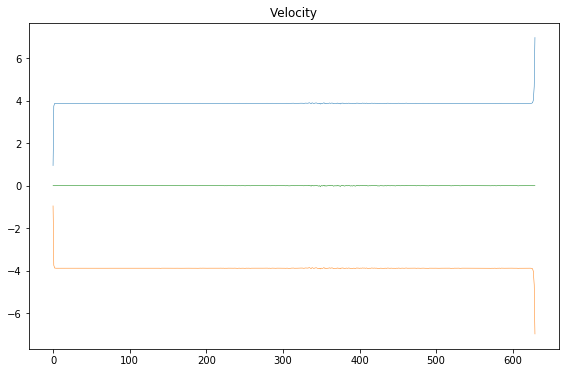

In [25]:
#velocity

upper_error_bars = x_mean[:,1] + x_std[:,1]
lower_error_bars = x_mean[:,1] - x_std[:,1]

plt.plot(x_mean[:,1],color='green',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Velocity')

Text(0.5,1,'Acceleration')

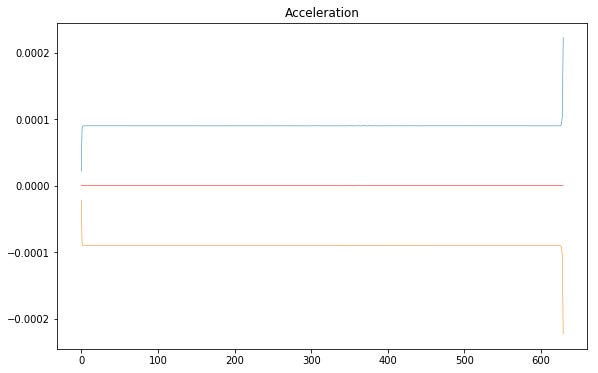

In [26]:
#acceleration

upper_error_bars = x_mean[:,2] + x_std[:,2]
lower_error_bars = x_mean[:,2] - x_std[:,2]

plt.plot(x_mean[:,2],color='red',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Acceleration')

## Estimated Position vs Price

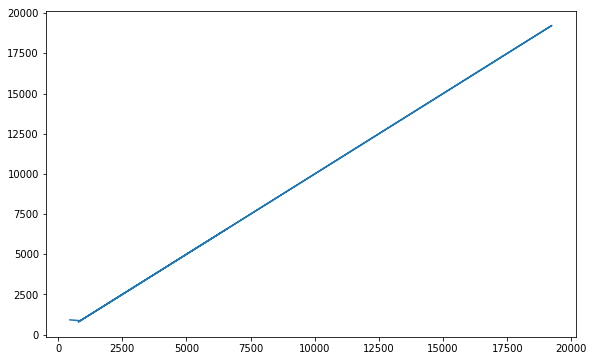

In [27]:
plt.plot(x_mean[:,0],df.weightedAverage)
#plt.plot(x_mean[:,0], color='b', linewidth=.45)
#plt.plot(df.weightedAverage, color='y',linewidth=.45)

In [28]:
# This linear relationship indicates that the estimated position and price values were practically equal 
# after the beginning period.

## Monthly subsets

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


(2017, 1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


count    26.000000
mean      0.000341
std       0.001281
min      -0.000960
25%      -0.000068
50%       0.000080
75%       0.000224
max       0.005775
Name: velocity, dtype: float64
count    2.600000e+01
mean    -2.043236e-09
std      1.189018e-08
min     -5.065123e-08
25%     -3.013650e-09
50%     -3.791422e-10
75%      3.226894e-09
max      1.295458e-08
Name: acceleration, dtype: float64


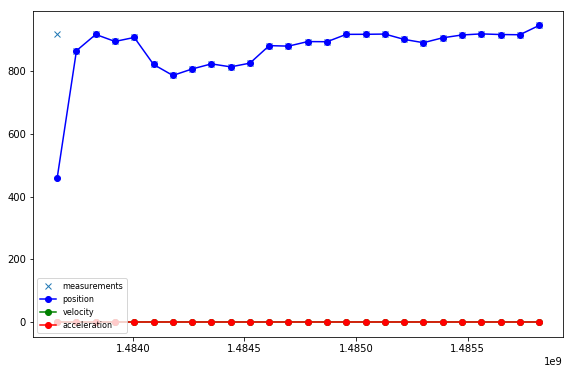

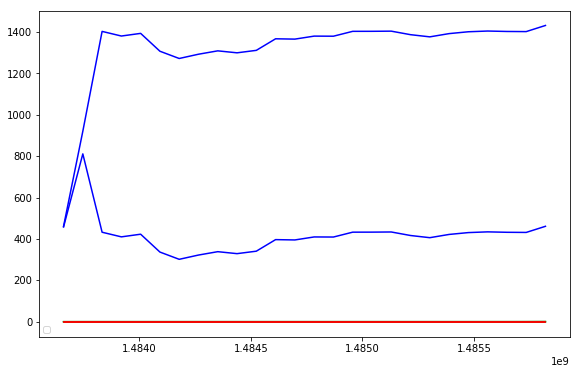

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.
/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonalit

(2017, 2)
count    28.000000
mean      0.000436
std       0.001567
min      -0.000629
25%      -0.000095
50%       0.000165
75%       0.000291
max       0.007997
Name: velocity, dtype: float64
count    2.800000e+01
mean    -3.292227e-09
std      1.377854e-08
min     -5.331888e-08
25%     -2.673183e-09
50%     -5.526739e-10
75%      2.517447e-09
max      1.198481e-08
Name: acceleration, dtype: float64


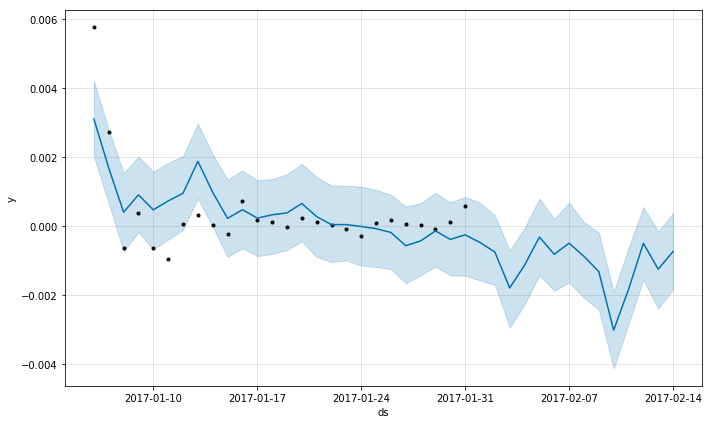

ValueError: view limit minimum -73638848.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

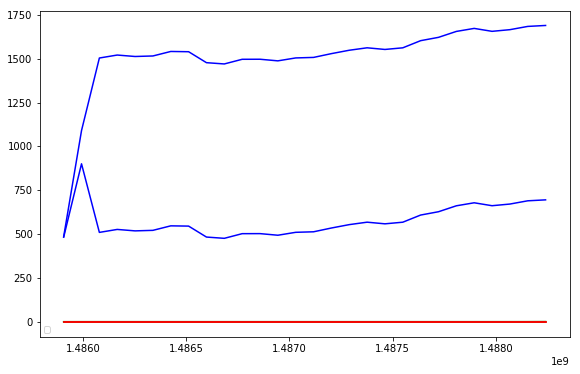

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 21.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 21.0.


(2017, 3)
count    31.000000
mean      0.000330
std       0.001924
min      -0.001623
25%      -0.000262
50%      -0.000070
75%       0.000315
max       0.009805
Name: velocity, dtype: float64
count    3.100000e+01
mean    -3.304849e-09
std      1.661241e-08
min     -6.972582e-08
25%     -5.796069e-09
50%      7.672569e-10
75%      4.029272e-09
max      1.138781e-08
Name: acceleration, dtype: float64


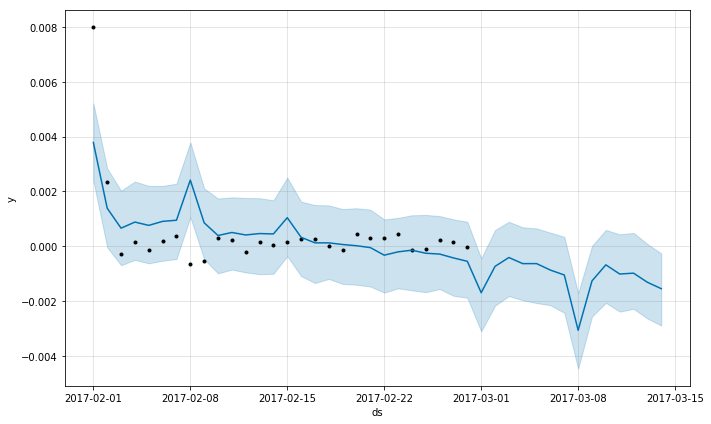

ValueError: view limit minimum -73772740.95 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

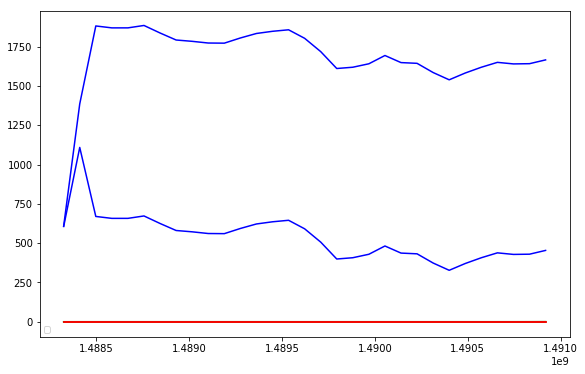

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 4)
count    30.000000
mean      0.000481
std       0.001606
min      -0.000366
25%      -0.000029
50%       0.000079
75%       0.000314
max       0.008468
Name: velocity, dtype: float64
count    3.000000e+01
mean    -3.263991e-09
std      1.340784e-08
min     -5.719945e-08
25%     -2.884028e-09
50%     -1.695887e-10
75%      2.559848e-09
max      6.471709e-09
Name: acceleration, dtype: float64


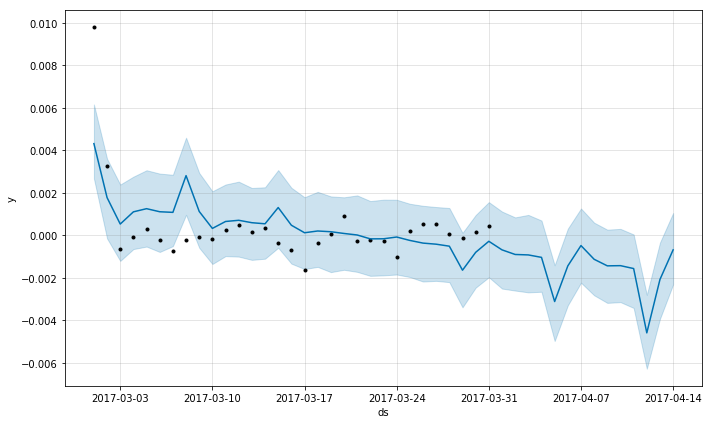

ValueError: view limit minimum -73902311.55 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

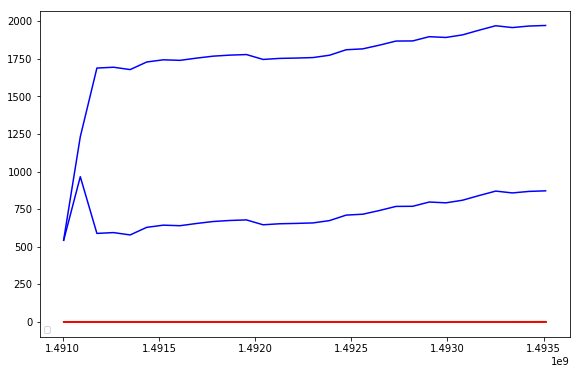

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 5)
count    31.000000
mean      0.000701
std       0.002620
min      -0.004996
25%      -0.000012
50%       0.000366
75%       0.000888
max       0.012649
Name: velocity, dtype: float64
count    3.100000e+01
mean    -5.651231e-09
std      2.642185e-08
min     -8.263365e-08
25%     -1.889283e-08
50%     -5.234048e-10
75%      6.152814e-09
max      4.732542e-08
Name: acceleration, dtype: float64


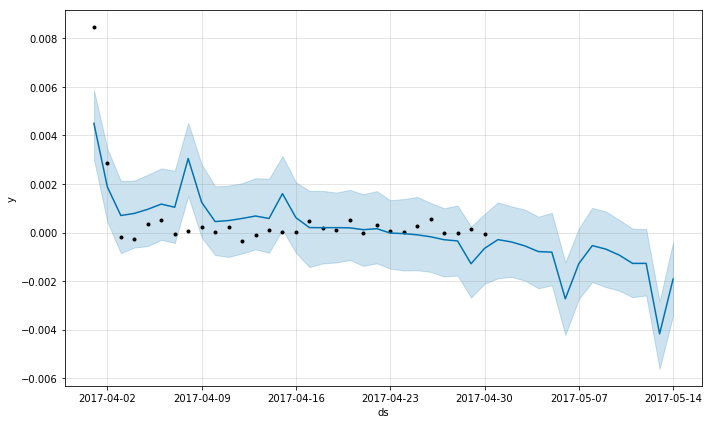

ValueError: view limit minimum -74036199.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

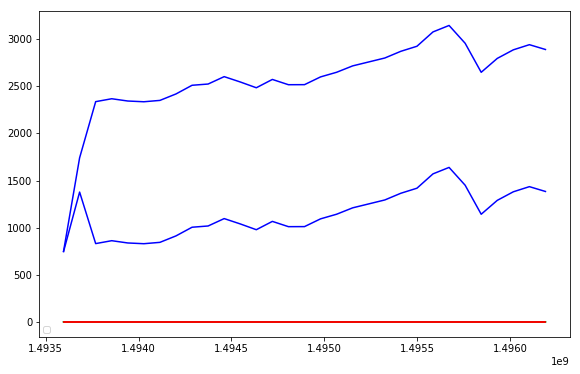

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 6)
count    30.000000
mean      0.000803
std       0.003718
min      -0.004121
25%      -0.000943
50%       0.000240
75%       0.001323
max       0.017801
Name: velocity, dtype: float64
count    3.000000e+01
mean    -6.617239e-09
std      3.540226e-08
min     -1.230684e-07
25%     -1.834632e-08
50%      1.199905e-09
75%      1.503780e-08
max      4.984313e-08
Name: acceleration, dtype: float64


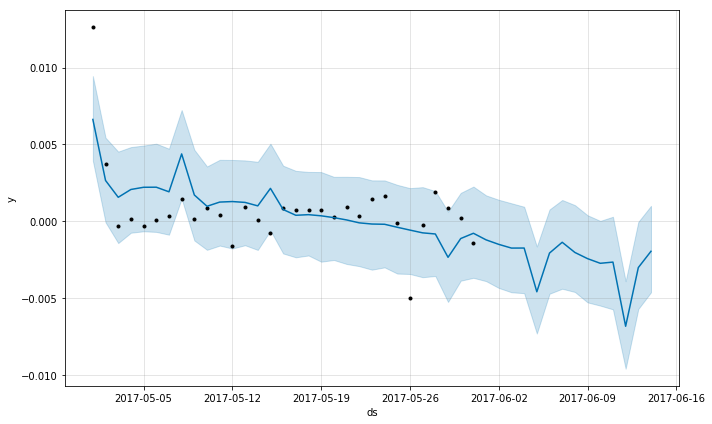

ValueError: view limit minimum -74165767.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

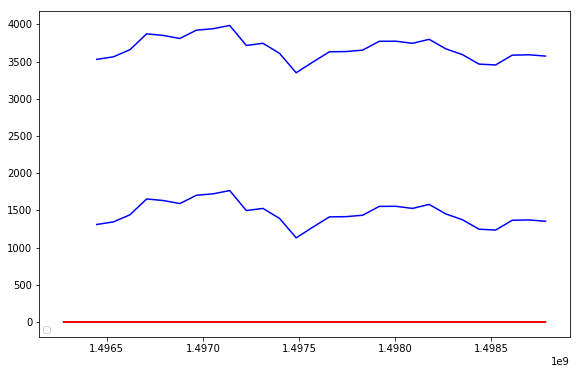

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 7)
count    31.000000
mean      0.000926
std       0.003657
min      -0.002391
25%      -0.000671
50%      -0.000068
75%       0.001206
max       0.017986
Name: velocity, dtype: float64
count    3.100000e+01
mean    -5.184919e-09
std      3.180207e-08
min     -1.139076e-07
25%     -1.672186e-08
50%     -6.924698e-09
75%      1.828173e-08
max      4.619366e-08
Name: acceleration, dtype: float64


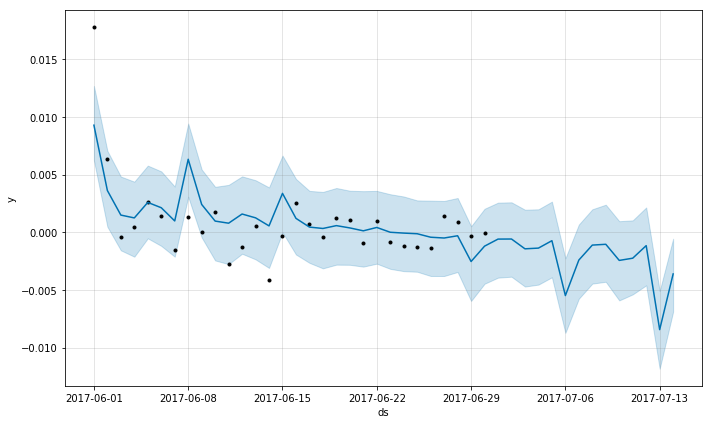

ValueError: view limit minimum -74299654.95 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

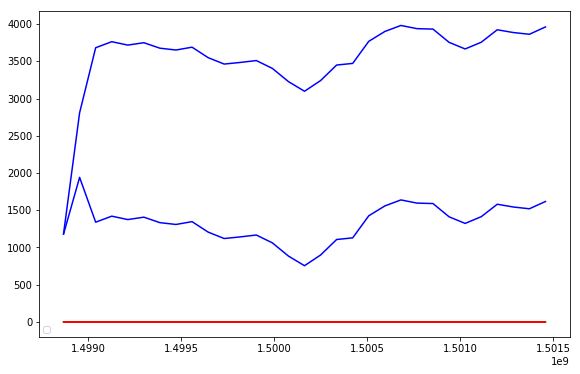

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 8)
count    31.000000
mean      0.001615
std       0.004038
min      -0.003435
25%      -0.000219
50%       0.000851
75%       0.002127
max       0.020441
Name: velocity, dtype: float64
count    3.100000e+01
mean    -6.055933e-09
std      4.207329e-08
min     -1.507157e-07
25%     -2.076709e-08
50%     -2.443736e-09
75%      1.946991e-08
max      6.660305e-08
Name: acceleration, dtype: float64


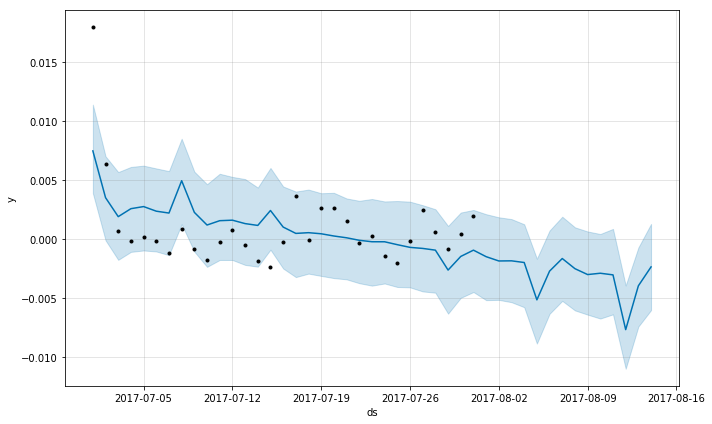

ValueError: view limit minimum -74433543.45 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

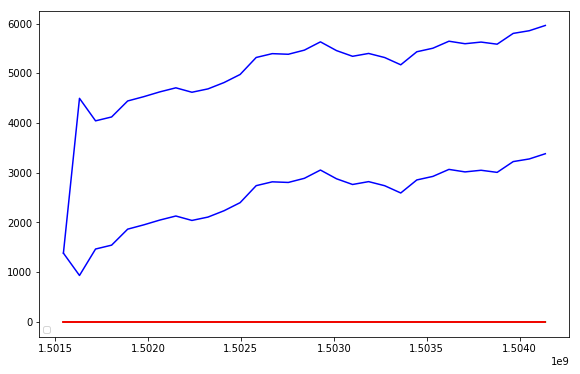

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 9)
count    30.000000
mean      0.001356
std       0.006829
min      -0.004919
25%      -0.001345
50%       0.000057
75%       0.002165
max       0.033318
Name: velocity, dtype: float64
count    3.000000e+01
mean    -9.022920e-09
std      6.697256e-08
min     -2.678089e-07
25%     -2.322295e-08
50%     -3.699395e-09
75%      2.861543e-08
max      8.129858e-08
Name: acceleration, dtype: float64


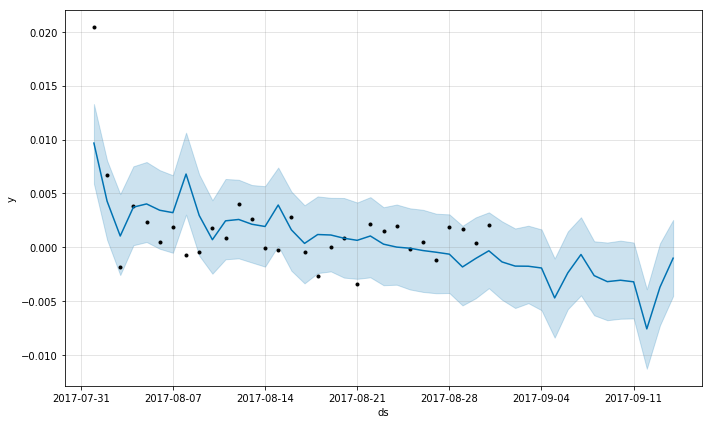

ValueError: view limit minimum -74563110.9 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

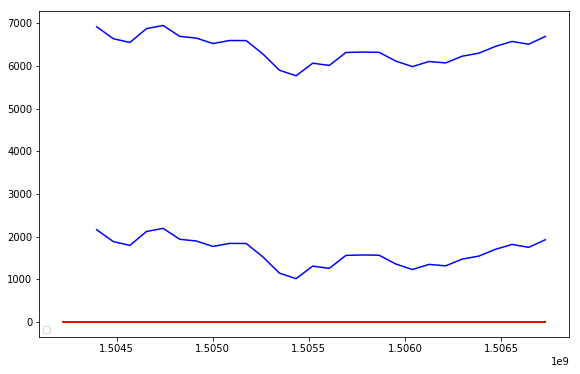

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 10)
count    31.000000
mean      0.002186
std       0.006932
min      -0.004534
25%      -0.000807
50%       0.001511
75%       0.002564
max       0.036319
Name: velocity, dtype: float64
count    3.100000e+01
mean    -1.185730e-08
std      6.976191e-08
min     -2.507754e-07
25%     -2.792849e-08
50%      4.769540e-09
75%      2.686218e-08
max      7.080354e-08
Name: acceleration, dtype: float64


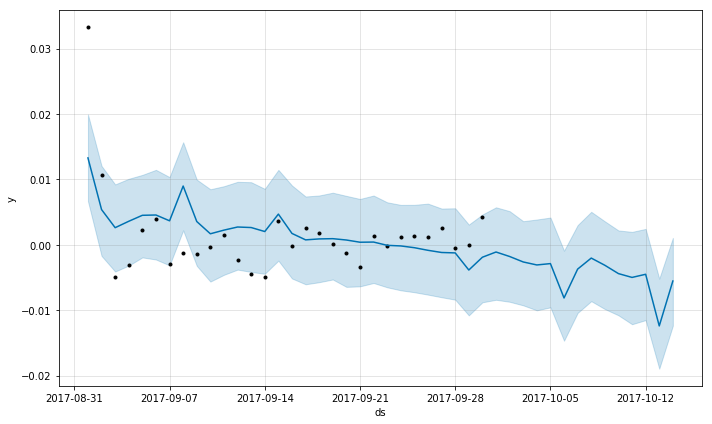

ValueError: view limit minimum -74696998.35000001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

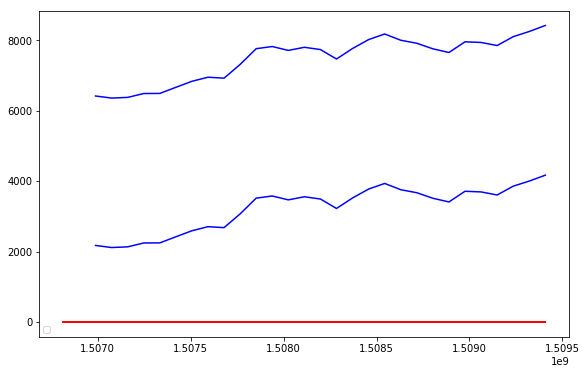

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 11)
count    30.000000
mean      0.003194
std       0.011305
min      -0.012086
25%      -0.001260
50%       0.001170
75%       0.004856
max       0.054863
Name: velocity, dtype: float64
count    3.000000e+01
mean    -2.983635e-08
std      1.048558e-07
min     -4.139133e-07
25%     -4.468997e-08
50%     -1.012866e-08
75%      2.763245e-08
max      1.021789e-07
Name: acceleration, dtype: float64


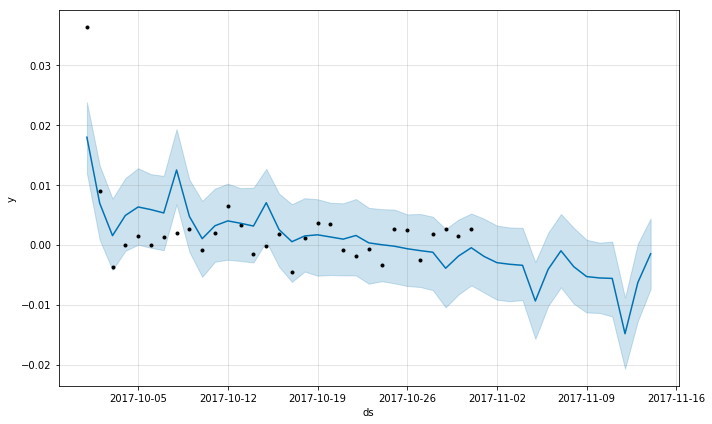

ValueError: view limit minimum -74826566.85000001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

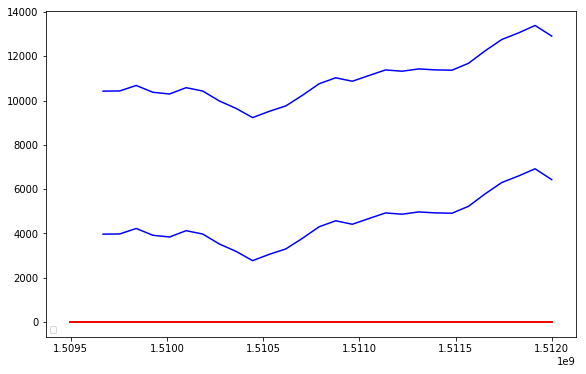

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2017, 12)
count    31.000000
mean      0.004902
std       0.022024
min      -0.037606
25%      -0.006147
50%       0.001843
75%       0.017237
max       0.088560
Name: velocity, dtype: float64
count    3.100000e+01
mean    -1.158840e-08
std      2.584144e-07
min     -6.435133e-07
25%     -1.739390e-07
50%      2.706993e-08
75%      1.536042e-07
max      4.230356e-07
Name: acceleration, dtype: float64


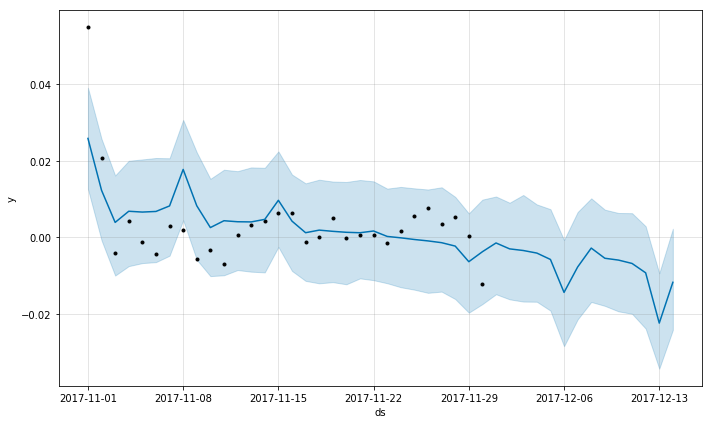

ValueError: view limit minimum -74960454.3 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

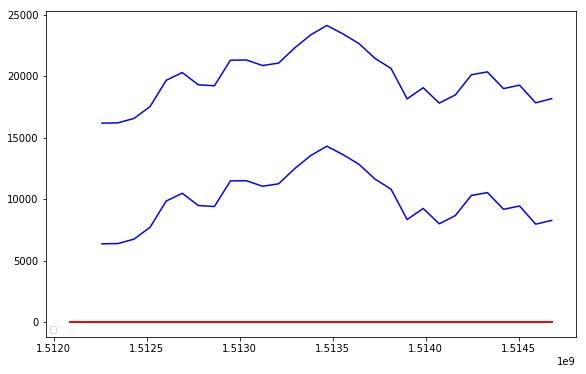

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


(2018, 1)
count    31.000000
mean      0.002980
std       0.023745
min      -0.031192
25%      -0.008974
50%      -0.000348
75%       0.007995
max       0.108279
Name: velocity, dtype: float64
count    3.100000e+01
mean    -3.596696e-08
std      2.334446e-07
min     -8.731984e-07
25%     -9.635707e-08
50%      1.841412e-08
75%      1.079069e-07
max      4.173782e-07
Name: acceleration, dtype: float64


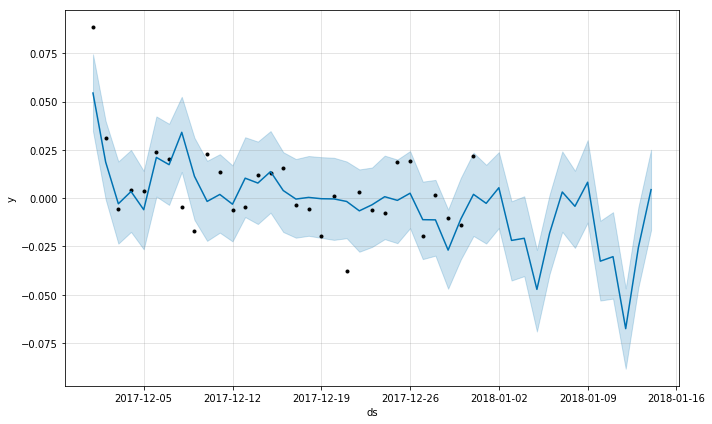

In [ ]:
d = dict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items():
    print(i)
    v_a(df_month)